In [16]:
import cs109style
cs109style.customize_mpl()
cs109style.customize_css()

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import requests
from pattern import web
import json
import re

Setting custom matplotlib visual style
Setting custom CSS for the IPython Notebook


## Fetching population data from Wikipedia

In this example we will fetch data about countries and their population from Wikipedia.

http://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population has several tables for individual countries, subcontinents as well as different years. We will combine the data for all countries and all years in a single panda dataframe and visualize the change in population for different countries.

###We will go through the following steps:
* fetching html with embedded data
* parsing html to extract the data
* collecting the data in a panda dataframe
* displaying the data

To give you some starting points for your homework, we will also show the different sub-steps that can be taken to reach the presented solution.

## Fetching the Wikipedia site

In [3]:
url = 'http://en.wikipedia.org/wiki/List_of_countries_by_past_and_future_population'
wiki = requests.get(url)
print wiki.status_code
print wiki.headers
#print wiki.json() 
website_html = wiki.text
#print website_html

200
{'content-length': '91191', 'x-varnish': '3913155559 3874471243, 3342101014 3220392478', 'x-analytics': 'page_id=20928488;ns=0;https=1;WMF-Last-Access=02-Jul-2015', 'content-language': 'en', 'x-content-type-options': 'nosniff', 'x-powered-by': 'HHVM/3.6.1', 'x-cache': 'cp1068 hit (6), cp1067 frontend hit (21)', 'accept-ranges': 'bytes', 'content-encoding': 'gzip', 'vary': 'Accept-Encoding,Cookie', 'server': 'nginx/1.9.2', 'last-modified': 'Fri, 26 Jun 2015 22:53:16 GMT', 'connection': 'keep-alive', 'via': '1.1 varnish, 1.1 varnish', 'strict-transport-security': 'max-age=31536000', 'x-ua-compatible': 'IE=Edge', 'cache-control': 'private, s-maxage=0, max-age=0, must-revalidate', 'date': 'Thu, 02 Jul 2015 19:07:02 GMT', 'content-type': 'text/html; charset=UTF-8', 'age': '73030'}


## Parsing html data

In [4]:
def get_population_html_tables(html):
    """Parse html and return html tables of wikipedia population data."""

    dom = web.Element(html)

    ### 0. step: look at html source!
    #### 1. step: get all tables
    tbls = dom.by_class("sortable wikitable")
    #### 2. step: get all tables we care about
    return tbls

tables = get_population_html_tables(website_html)
print "table length: %d" %len(tables)
for t in tables:
    print t.attributes


table length: 6
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}
{u'style': u'text-align: right', u'class': u'sortable wikitable'}


In [5]:
def table_type(tbl):
    ### Extract the table type
    header_row = tbl.by_tag(u'tr')[0]
    # Table type is first column in header row
    tbl_type = header_row.by_tag(u'th')[0].content
    return tbl_type
        

# group the tables by type
tables_by_type = defaultdict(list)  # defaultdicts have a default value that is inserted when a new key is accessed
for tbl in tables:
    tables_by_type[table_type(tbl)].append(tbl)

print dict(tables_by_type)

{u'Country or territory': [Element(tag=u'table'), Element(tag=u'table'), Element(tag=u'table')], u'(Sub)continent': [Element(tag=u'table'), Element(tag=u'table'), Element(tag=u'table')]}


## Extracting data and filling it into a dictionary

In [19]:
def recursive_dict():
    return defaultdict(recursive_dict)
result_dict = recursive_dict()

def parse_one_table(tbl, result_dict):
 
    rows = tbl.by_tag(u'tr')
    header_row = rows[0].by_tag(u'th')
    n_rows = len(rows)
    n_cols = len(header_row)
    
    years = []
    index = []
    # get the years, skip the "%" columns
    for i in range(1, n_cols):
        if header_row[i].content != u'%':
            index.append(i)
            years.append(int(header_row[i].content))
        
    for j in range(1, n_rows):
        row_elements = rows[j].by_tag(u'td')
        country_name = row_elements[0].by_tag(u'a')[0].content
        populations = []
        for k in index:
            populations.append(int(row_elements[k].content.replace(',', '')))
            
        result_dict[country_name].update(dict(zip(years, populations)))
        
    return result_dict

#parse_one_table(tables_by_type['Country or territory'][0], result_dict)
 

defaultdict(<function recursive_dict at 0x0000000010A8C908>, {u'1955': u'16,050', u'1950': u'14,011', u'1980': u'24,593', u'1965': u'20,071', u'1975': u'23,209', u'1960': u'18,267', u'1970': u'21,750'})


In [20]:
def get_countries_population(tables, result_dict):
    """Extract population data for countries from all tables and store it in dictionary."""

    # 1. step: try to extract data for a single table
    for table in tables:
        result_dict = parse_one_table(table, result_dict)

    # 2. step: iterate over all tables, extract headings and actual data and combine data into single dict
    
    return result_dict


result_dict = get_countries_population(tables_by_type['Country or territory'], result_dict)
print dict(result_dict['Lithuania'])

{1985: 3587, 2050: 2788, 1990: 3695, 1995: 3674, 2000: 3654, 2005: 3597, 2010: 3545, 1950: 2553, 2015: 3495, 1955: 2614, 2020: 3435, 1960: 2765, 2025: 3356, 1965: 2959, 2030: 3257, 1970: 3138, 2035: 3147, 1975: 3305, 2040: 3031, 1980: 3435, 2045: 2912}


## Creating a dataframe from a dictionary

In [26]:
# create dataframe

df = pd.DataFrame.from_dict(result_dict, orient='index')
# sort based on year
#df.sort(axis=1,inplace=True)
df = df.reindex_axis(sorted(df.columns), axis=1)
df

,1950,1955,1960,1965,1970,1975,1980,1985,1990,1995,...,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050
Afghanistan,8150,8891,9829,10998,12431,14132,15044,13120,13568,19445,...,26335,29121,32564,36644,41117,45665,50195,54717,59255,63795
Albania,1227,1392,1623,1884,2157,2401,2671,2957,3245,3158,...,3025,2987,3029,3075,3105,3103,3062,2994,2912,2824
Algeria,8893,9842,10909,11963,13932,16140,18806,22008,25089,28089,...,32561,34586,36640,38594,40290,41641,42663,43425,43940,44163
American Samoa,19,20,20,25,27,30,32,39,47,54,...,62,66,71,75,79,84,87,91,95,98
Andorra,6,6,8,14,20,27,34,45,53,63,...,76,85,86,86,85,84,83,81,78,75
Angola,4118,4423,4797,5135,5606,6050,7206,8390,9485,11000,...,14770,17043,19625,22484,25673,29155,32910,36948,41280,45888
Anguilla,5,5,6,6,6,6,7,7,8,10,...,13,15,16,18,20,21,23,24,26,27
Antigua and Barbuda,46,51,55,59,66,68,69,64,64,69,...,81,87,92,98,104,109,114,117,120,123
Argentina,17150,18928,20616,22283,23962,26082,28370,30672,33036,35274,...,39181,41343,43432,45379,47165,48795,50273,51573,52663,53511
Armenia,1355,1565,1869,2206,2520,2834,3115,3374,3377,3069,...,2983,2967,2984,3017,3044,3051,3042,3023,2991,2943


## Some data accessing functions for a panda dataframe

In [30]:
subtable = df.iloc[0:2, 0:2]
print "subtable"
print subtable
print ""

column = df[1955]
print "column"
print column
print ""

row = df.ix[0] #row 0
print "row"
print row
print ""

rows = df.ix[:2] #rows 0,1
print "rows"
print rows
print ""

element = df.ix[0,1955] #element
print "element"
print element
print ""

# max along column
print "max"
print df[1950].max()
print ""

# axes
print "axes"
print df.axes
print ""

row = df.ix[0]
print "row info"
print row
print row.name
print row.index
print ""

countries =  df.index
print "countries"
print countries
print ""

print "Austria"
print df.ix['Austria']

subtable
             1950  1955
Afghanistan  8150  8891
Albania      1227  1392

column
Afghanistan             8891
Albania                 1392
Algeria                 9842
American Samoa            20
Andorra                    6
Angola                  4423
Anguilla                   5
Antigua and Barbuda       51
Argentina              18928
Armenia                 1565
Aruba                     54
Australia               9277
Austria                 6947
Azerbaijan              3314
Bahamas                   87
...
United Arab Emirates                83
United Kingdom                   50946
United States                   165069
United States Virgin Islands        28
Uruguay                           2353
Uzbekistan                        7232
Vanuatu                             59
Venezuela                         6170
Vietnam                          27738
Wallis and Futuna                    7
West Bank                          788
Western Sahara                      16
Yeme

## Plotting population of 4 countries

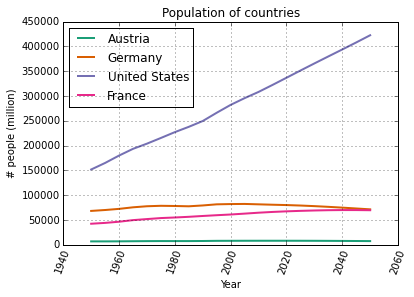

In [31]:
plotCountries = ['Austria', 'Germany', 'United States', 'France']
    
for country in plotCountries:
    row = df.ix[country]
    plt.plot(row.index, row, label=row.name ) 
    
plt.ylim(ymin=0) # start y axis at 0

plt.xticks(rotation=70)
plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("# people (million)")
plt.title("Population of countries")

## Plot 5 most populous countries from 2010 and 2060

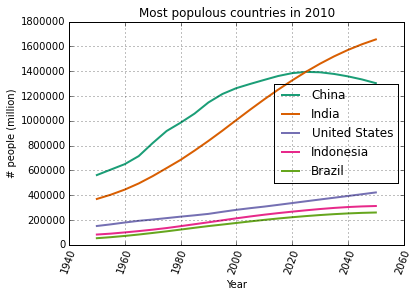

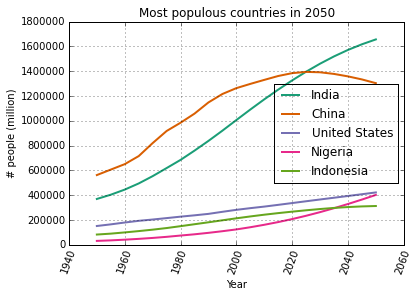

In [36]:
def plot_populous(df, year):
    # sort table depending on data value in year column
    df_by_year = df.sort(year, ascending=False)
    
    plt.figure()
    for i in range(5):  
        row = df_by_year.ix[i]
        plt.plot(row.index, row, label=row.name ) 
            
    plt.ylim(ymin=0)
    
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Year")
    plt.ylabel("# people (million)")
    plt.title("Most populous countries in %d" % year)

plot_populous(df, 2010)
plot_populous(df, 2050)

In [37]:
df.sort(2010, ascending=False)

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc3 in position 4792: ordinal not in range(128)